# 15. 문자를 읽을 수 있는 딥러닝

**문자를 읽는 OCR 모델의 구조를 배우고, keras-ocr과 테서랙트 엔진을 써본다.**

## 15-9. 프로젝트 : 다양한 OCR모델 비교하기

---

## 목차
- Step1. 검증용 데이터셋 준비
- Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
- Step3. 테스트 결과 정리
- Step4. 결과 분석과 결론 제시
- 회고

---

### Step1. 검증용 데이터셋 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Colab 라이브러리 오류 해결

|번호|오류|설명|해결|
|:---:|---|---|---|
|1|ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts. tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.|tf-esitmator-nightly 2.8.0 에는tf-estimator-nightly==2.8.0.dev2021122109가 필요하다는 내용|!pip install tf-estimator-nightly==2.8.0.dev2021122109|
|2|ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.|imgaug 삭제 후 0.4.0 버전으로 설치 [[참고]](https://heroine-day.tistory.com/99)|!pip uninstall imgaug !pip install imgaug==0.4.0|
|3|ImportError: cannot import name '_registerMatType' from 'cv2.cv2' (/usr/local/lib/python3.7/dist-packages/cv2/cv2.cpython-37m-x86_64-linux-gnu.so)|opencv-python(4.1.2.30)이 opencv-python-headless와 일치하지 않기 때문 => opencv-python-headless 를 4.1.2.30 으로 다운그레이드해야 함[[참고]](https://exerror.com/importerror-cannot-import-name-_registermattype-from-cv2-cv2/)|!pip install opencv-python-headless==4.1.2.30|
|4|annotate() missing 1 required positional argument: 's'|matplotlib v3.3.0보다 낮아서 발생하는 오류 => matplotlib 업그레이드로 해결 완료|!pip install --upgrade matplotlib|
|5|TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.|pytesseract 설치하기 전에 tesseract-ocr 을 설치하면 해결됨[[참고]](https://lapina.tistory.com/82)|!sudo apt install tesseract-ocr !pip install pytesseract|

In [2]:
# ERROR, pip dependency resolver/conflict 문구 해결

!pip install imgaug==0.4.0
!pip install tf-estimator-nightly==2.8.0.dev2021122109
!pip install opencv-python-headless==4.1.2.30

In [3]:
# 라이브러리 설치
!pip install --upgrade matplotlib
!sudo apt install tesseract-ocr
!pip install google-cloud-vision keras_ocr pytesseract easyocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


- 라이브러리 불러오기

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

from google.cloud import vision
import io

import keras_ocr
import cv2

import os
import pytesseract
from PIL import Image
from pytesseract import Output

import glob
import easyocr

- 데이터 불러오기

In [5]:
def get_img_path_n_file_list(work_dir= 'drive/MyDrive/Colab Notebooks/ocr_python/images', img_ext='.jpg'):
  img_path_list = [img_path for img_path in glob.glob(work_dir + '/*') if img_path.endswith(img_ext)]
  img_file_list = [img_file for img_file in os.listdir(work_dir) if img_file.endswith(img_ext)]
  return img_path_list, img_file_list

In [6]:
work_dir = 'drive/MyDrive/Colab Notebooks/ocr_python/images'
img_ext = '.jpg'
img_path_list, img_file_list = get_img_path_n_file_list(work_dir, img_ext)

In [7]:
img_path_list.sort()
img_path_list

['drive/MyDrive/Colab Notebooks/ocr_python/images/book_01.jpg',
 'drive/MyDrive/Colab Notebooks/ocr_python/images/book_02.jpg',
 'drive/MyDrive/Colab Notebooks/ocr_python/images/book_03.jpg',
 'drive/MyDrive/Colab Notebooks/ocr_python/images/book_04.jpg',
 'drive/MyDrive/Colab Notebooks/ocr_python/images/book_05.jpg']

In [8]:
img_file_list.sort()
img_file_list

['book_01.jpg', 'book_02.jpg', 'book_03.jpg', 'book_04.jpg', 'book_05.jpg']

- 데이터 확인

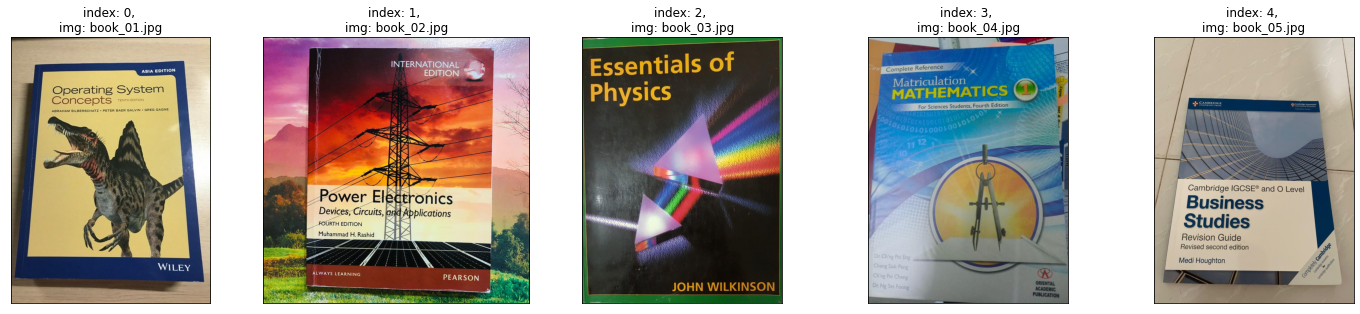

In [9]:
plt.figure(figsize=(20, 20))

for i, (img_path, img_file) in enumerate(zip(img_path_list, img_file_list)):
    plt.subplot(5, 5, i+1)
    plt.title(f'index: {i}, \nimg: {img_file}')

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

#### Google OCR API

In [10]:
# 인증키
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  'drive/MyDrive/Colab Notebooks/ocr_python/google_api_key/my_google_api_key.json'

In [11]:
# Google OCR API 이용 함수
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    only_text_list = []
    vertices_tuple_list = []
    for text in texts:
       print('\n"{}"'.format(text.description))
       only_text_list.append(text.description)

       vertices = (['({},{})'.format(vertex.x, vertex.y)
                  for vertex in text.bounding_poly.vertices])
    
       vertices_tuple = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
       vertices_tuple_list.append(vertices_tuple)

       print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    return only_text_list, vertices_tuple_list

In [12]:
google_ocr_dict = {}
for img_path, img_file in zip(img_path_list, img_file_list):
    print(f'---------------{img_file}---------------')
    texts, vertices_list = detect_text(img_path)
    google_ocr_dict[img_path] = {'texts': texts, 'vertices_list': vertices_list}

---------------book_01.jpg---------------
Texts:

"ASIA EDITION
Operating System
Concepts
TENTH EDITION
ABRAHAM SILBERSCHATZ PETER BAER GALVIN. GREG GAGNE
WILEY
"
bounds: (102,81),(447,81),(447,586),(102,586)

"ASIA"
bounds: (327,84),(354,83),(354,90),(327,91)

"EDITION"
bounds: (360,83),(409,81),(409,88),(360,90)

"Operating"
bounds: (104,124),(253,122),(253,151),(104,153)

"System"
bounds: (265,123),(381,121),(381,145),(265,147)

"Concepts"
bounds: (103,147),(250,147),(250,173),(103,173)

"TENTH"
bounds: (267,157),(295,156),(295,162),(267,163)

"EDITION"
bounds: (299,156),(331,155),(331,162),(299,163)

"ABRAHAM"
bounds: (102,183),(146,182),(146,188),(102,189)

"SILBERSCHATZ"
bounds: (151,184),(218,183),(218,189),(151,190)

"PETER"
bounds: (230,183),(257,183),(257,188),(230,188)

"BAER"
bounds: (263,182),(285,182),(285,188),(263,188)

"GALVIN."
bounds: (290,182),(329,181),(329,187),(290,188)

"GREG"
bounds: (337,180),(359,180),(359,188),(337,188)

"GAGNE"
bounds: (365,180),(393,180),(

In [13]:
google_ocr_dict

{'drive/MyDrive/Colab Notebooks/ocr_python/images/book_01.jpg': {'texts': ['ASIA EDITION\nOperating System\nConcepts\nTENTH EDITION\nABRAHAM SILBERSCHATZ PETER BAER GALVIN. GREG GAGNE\nWILEY\n',
   'ASIA',
   'EDITION',
   'Operating',
   'System',
   'Concepts',
   'TENTH',
   'EDITION',
   'ABRAHAM',
   'SILBERSCHATZ',
   'PETER',
   'BAER',
   'GALVIN.',
   'GREG',
   'GAGNE',
   'WILEY'],
  'vertices_list': [[(102, 81), (447, 81), (447, 586), (102, 586)],
   [(327, 84), (354, 83), (354, 90), (327, 91)],
   [(360, 83), (409, 81), (409, 88), (360, 90)],
   [(104, 124), (253, 122), (253, 151), (104, 153)],
   [(265, 123), (381, 121), (381, 145), (265, 147)],
   [(103, 147), (250, 147), (250, 173), (103, 173)],
   [(267, 157), (295, 156), (295, 162), (267, 163)],
   [(299, 156), (331, 155), (331, 162), (299, 163)],
   [(102, 183), (146, 182), (146, 188), (102, 189)],
   [(151, 184), (218, 183), (218, 189), (151, 190)],
   [(230, 183), (257, 183), (257, 188), (230, 188)],
   [(263, 182)

In [14]:
google_ocr_text_pos_list = []
google_ocr_text_list = []
for i, (img_path, result_dict) in enumerate(google_ocr_dict.items()):
    google_ocr_text_list.append((i, result_dict['texts']))
    google_ocr_text_pos_list.append((i, result_dict['vertices_list']))

In [15]:
google_ocr_text_pos_list

[(0,
  [[(102, 81), (447, 81), (447, 586), (102, 586)],
   [(327, 84), (354, 83), (354, 90), (327, 91)],
   [(360, 83), (409, 81), (409, 88), (360, 90)],
   [(104, 124), (253, 122), (253, 151), (104, 153)],
   [(265, 123), (381, 121), (381, 145), (265, 147)],
   [(103, 147), (250, 147), (250, 173), (103, 173)],
   [(267, 157), (295, 156), (295, 162), (267, 163)],
   [(299, 156), (331, 155), (331, 162), (299, 163)],
   [(102, 183), (146, 182), (146, 188), (102, 189)],
   [(151, 184), (218, 183), (218, 189), (151, 190)],
   [(230, 183), (257, 183), (257, 188), (230, 188)],
   [(263, 182), (285, 182), (285, 188), (263, 188)],
   [(290, 182), (329, 181), (329, 187), (290, 188)],
   [(337, 180), (359, 180), (359, 188), (337, 188)],
   [(365, 180), (393, 180), (393, 187), (365, 187)],
   [(367, 566), (447, 569), (446, 586), (366, 583)]]),
 (1,
  [[(201, 99), (872, 99), (872, 990), (201, 990)],
   [(521, 99), (793, 104), (793, 130), (521, 125)],
   [(656, 132), (794, 134), (793, 168), (656, 1

In [16]:
google_ocr_text_list

[(0,
  ['ASIA EDITION\nOperating System\nConcepts\nTENTH EDITION\nABRAHAM SILBERSCHATZ PETER BAER GALVIN. GREG GAGNE\nWILEY\n',
   'ASIA',
   'EDITION',
   'Operating',
   'System',
   'Concepts',
   'TENTH',
   'EDITION',
   'ABRAHAM',
   'SILBERSCHATZ',
   'PETER',
   'BAER',
   'GALVIN.',
   'GREG',
   'GAGNE',
   'WILEY']),
 (1,
  ['INTERNATIONAL\nEDITION\nPower Electronics\nDevices, Circuits, and Applications\nFOURTH EDITION\nMuhammad H. Rashid\nALWAYS LEARNING\nPEARSON\n',
   'INTERNATIONAL',
   'EDITION',
   'Power',
   'Electronics',
   'Devices,',
   'Circuits,',
   'and',
   'Applications',
   'FOURTH',
   'EDITION',
   'Muhammad',
   'H.',
   'Rashid',
   'ALWAYS',
   'LEARNING',
   'PEARSON']),
 (2,
  ['Essentials of\nPhysics\nJOHN WILKINSON\n',
   'Essentials',
   'of',
   'Physics',
   'JOHN',
   'WILKINSON']),
 (3,
  ["n0101010101001010101010011A\n0101001010110011e\nA Very Short\nFor Bank's\nCon\nComplete Reference\nSA/SA-IN\nCA/CA\nMatriculation\nMATHEMATICS\nFor Scienc

#### keras-ocr

In [17]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [18]:
images = [keras_ocr.tools.read(img_path) for img_path in img_path_list]
prediction_groups = [pipeline.recognize([img_path]) for img_path in img_path_list]

In [19]:
def draw_keras_ocr(images, prediction_groups):
  # Plot the predictions
  fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
  fig.tight_layout()
  for idx, ax in enumerate(axs):
      keras_ocr.tools.drawAnnotations(image=images[idx], 
                                      predictions=prediction_groups[idx][0], ax=ax)

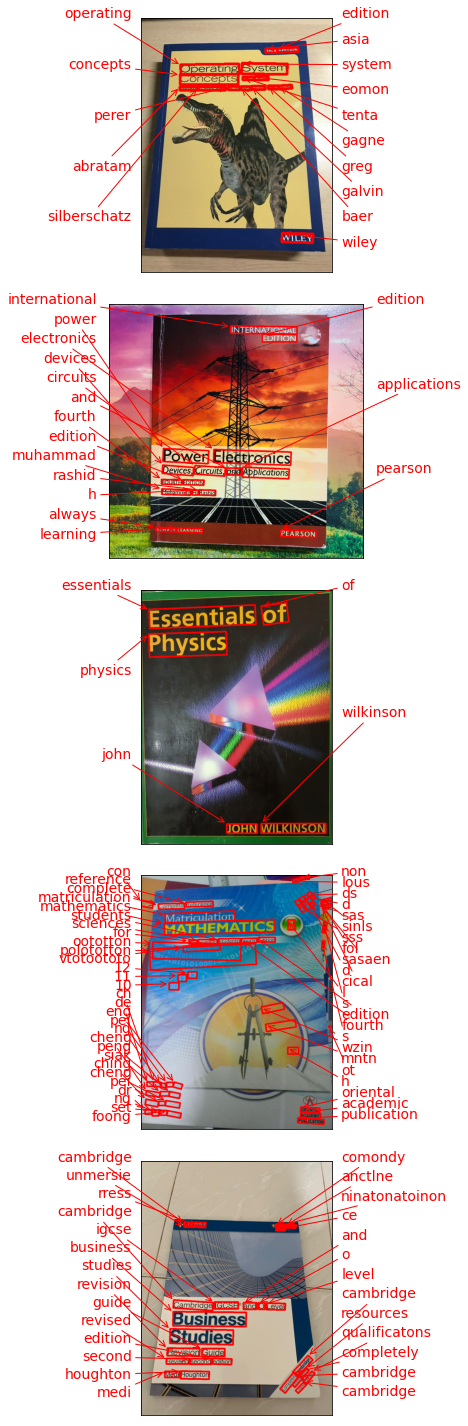

In [20]:
draw_keras_ocr(images, prediction_groups)

In [21]:
keras_ocr_dict = {}
for idx, img_path in enumerate(img_path_list):
  keras_ocr_dict[img_path] = prediction_groups[idx][0]

In [22]:
keras_ocr_dict

{'drive/MyDrive/Colab Notebooks/ocr_python/images/book_01.jpg': [('edition',
   array([[357.68805,  81.51301],
          [411.88562,  79.25477],
          [412.3518 ,  90.44367],
          [358.15424,  92.70191]], dtype=float32)),
  ('asia', array([[326.,  82.],
          [356.,  82.],
          [356.,  93.],
          [326.,  93.]], dtype=float32)),
  ('system', array([[264.07812 , 120.816086],
          [383.19446 , 122.110825],
          [382.8913  , 149.99883 ],
          [263.77496 , 148.70409 ]], dtype=float32)),
  ('operating', array([[103.80293 , 124.06809 ],
          [256.88336 , 122.385895],
          [257.1844  , 149.7782  ],
          [104.10396 , 151.46039 ]], dtype=float32)),
  ('concepts', array([[102., 149.],
          [254., 149.],
          [254., 176.],
          [102., 176.]], dtype=float32)),
  ('eomon', array([[297., 155.],
          [333., 155.],
          [333., 164.],
          [297., 164.]], dtype=float32)),
  ('tenta', array([[266., 156.],
          [296., 1

In [23]:
keras_ocr_text_pos_list = []
keras_ocr_text_list = []
for idx, img_path in enumerate(img_path_list):
  keras_ocr_text_pos_list.append([idx, list(zip(*keras_ocr_dict[img_path]))[1]])
  keras_ocr_text_list.append([idx, list(zip(*keras_ocr_dict[img_path]))[0]])

In [24]:
keras_ocr_text_pos_list

[[0, (array([[357.68805,  81.51301],
          [411.88562,  79.25477],
          [412.3518 ,  90.44367],
          [358.15424,  92.70191]], dtype=float32), array([[326.,  82.],
          [356.,  82.],
          [356.,  93.],
          [326.,  93.]], dtype=float32), array([[264.07812 , 120.816086],
          [383.19446 , 122.110825],
          [382.8913  , 149.99883 ],
          [263.77496 , 148.70409 ]], dtype=float32), array([[103.80293 , 124.06809 ],
          [256.88336 , 122.385895],
          [257.1844  , 149.7782  ],
          [104.10396 , 151.46039 ]], dtype=float32), array([[102., 149.],
          [254., 149.],
          [254., 176.],
          [102., 176.]], dtype=float32), array([[297., 155.],
          [333., 155.],
          [333., 164.],
          [297., 164.]], dtype=float32), array([[266., 156.],
          [296., 156.],
          [296., 164.],
          [266., 164.]], dtype=float32), array([[360.7041 , 179.01096],
          [394.95343, 177.74246],
          [395.29456, 1

In [25]:
keras_ocr_text_list

[[0,
  ('edition',
   'asia',
   'system',
   'operating',
   'concepts',
   'eomon',
   'tenta',
   'gagne',
   'greg',
   'galvin',
   'perer',
   'baer',
   'abratam',
   'silberschatz',
   'wiley')],
 [1,
  ('international',
   'edition',
   'power',
   'electronics',
   'devices',
   'circuits',
   'applications',
   'and',
   'fourth',
   'edition',
   'muhammad',
   'h',
   'rashid',
   'always',
   'learning',
   'pearson')],
 [2, ('of', 'essentials', 'physics', 'wilkinson', 'john')],
 [3,
  ('non',
   'lous',
   'ds',
   'd',
   'sas',
   'sinls',
   'fol',
   'sss',
   'con',
   'sasaen',
   'reference',
   'd',
   'complete',
   'cical',
   'matriculation',
   'mathematics',
   'l',
   's',
   'edition',
   'fourth',
   'students',
   'sciences',
   'for',
   's',
   'oototton',
   'polototton',
   'vtotoototo',
   '12',
   '11',
   '10',
   'wzin',
   'mntn',
   'ot',
   'h',
   'de',
   'ch',
   'pei',
   'eng',
   'ng',
   'cheng',
   'siak',
   'peng',
   'ching',
   'pe

#### Tesseract

In [26]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lang='eng'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang=lang,    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_dict = {}
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            img_file = img_path.split('/')[-1][:-4]
            output_img_path = os.path.join(output_path, f"{img_file + '_' + str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_dict[output_img_path] = [(left, top), (left+width, top), (left+width, top+height), (left, top+height)]
            index += 1
    return cropped_image_dict

In [27]:
def recognize_images(cropped_image_path_list, lang='eng'):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text = recognized_data['text']
        print(text)
        text_list.append(text)
    print("Done")

    return text_list

In [28]:
output_dir = work_dir + '/tesseract_output'

tesseract_ocr_dict = {}
for img_path, img_file in zip(img_path_list, img_file_list):
    print(f'---------------{img_file}---------------')
    cropped_image_dict = crop_word_regions(img_path, output_dir)
    
    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
    text_list = recognize_images(cropped_image_dict.keys())
    tesseract_ocr_dict[img_file] = {'text_list': text_list, 'cropped_image_dict': cropped_image_dict}

---------------book_01.jpg---------------
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0000.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0001.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0002.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0003.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0004.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0005.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0006.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0007.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0008.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0009.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0010.png
drive/MyDrive/Colab Notebooks/ocr_python/images/tesserac

In [29]:
tesseract_ocr_dict

{'book_01.jpg': {'cropped_image_dict': {'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0000.png': [(321,
     70),
    (416, 70),
    (416, 99),
    (321, 99)],
   'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0001.png': [(104,
     123),
    (254, 123),
    (254, 149),
    (104, 149)],
   'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0002.png': [(265,
     123),
    (382, 123),
    (382, 147),
    (265, 147)],
   'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0003.png': [(102,
     150),
    (252, 150),
    (252, 174),
    (102, 174)],
   'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0004.png': [(267,
     156),
    (332, 156),
    (332, 164),
    (267, 164)],
   'drive/MyDrive/Colab Notebooks/ocr_python/images/tesseract_output/book_01_0005.png': [(101,
     184),
    (147, 184),
    (147, 190),
    (101, 190)],
   'drive/MyDrive/Colab Notebooks/ocr

In [30]:
tesseract_ocr_text_pos_list = []
tesseract_ocr_text_list = []
for i, (img_path, tesseract_ocr_result) in enumerate(tesseract_ocr_dict.items()):
  tesseract_ocr_text_list.append([i, tesseract_ocr_result['text_list']])
  tesseract_ocr_text_pos_list.append([i, list(tesseract_ocr_result['cropped_image_dict'].values())])

In [31]:
tesseract_ocr_text_pos_list

[[0,
  [[(321, 70), (416, 70), (416, 99), (321, 99)],
   [(104, 123), (254, 123), (254, 149), (104, 149)],
   [(265, 123), (382, 123), (382, 147), (265, 147)],
   [(102, 150), (252, 150), (252, 174), (102, 174)],
   [(267, 156), (332, 156), (332, 164), (267, 164)],
   [(101, 184), (147, 184), (147, 190), (101, 190)],
   [(150, 183), (219, 183), (219, 191), (150, 191)],
   [(223, 185), (226, 185), (226, 188), (223, 188)],
   [(229, 183), (259, 183), (259, 189), (229, 189)],
   [(262, 182), (286, 182), (286, 189), (262, 189)],
   [(288, 177), (323, 177), (323, 188), (288, 188)],
   [(327, 183), (330, 183), (330, 186), (327, 186)],
   [(334, 181), (359, 181), (359, 187), (334, 187)],
   [(362, 180), (394, 180), (394, 187), (362, 187)],
   [(0, 0), (488, 0), (488, 666), (0, 666)]]],
 [1,
  [[(391, 679), (423, 679), (423, 693), (391, 693)],
   [(505, 692), (507, 692), (507, 694), (505, 694)],
   [(228, 691), (346, 691), (346, 736), (228, 736)],
   [(344, 692), (488, 692), (488, 731), (344, 

In [32]:
tesseract_ocr_text_list

[[0,
  ['ASIA EDITION\n\x0c',
   'Operating\n\x0c',
   'System\n\x0c',
   'Concepts\n\x0c',
   'TENTH EDITION\n\x0c',
   'ABRAM AM\n\x0c',
   'SILBERSCHAT2Z\n\x0c',
   '>\n\x0c',
   'PET ERM\n\x0c',
   'BAER\n\x0c',
   'GALVIN\n\x0c',
   'r\n\x0c',
   'Coby Cs\n\x0c',
   'GAGNE\n\x0c',
   '; |\n\x0c']],
 [1,
  ['wn\n\x0c',
   '~\n\x0c',
   'Devices\n\x0c',
   '; Circuits,\n\x0c',
   'UP\n\x0c',
   'FOURTH\n\x0c',
   'EDITION\n\x0c',
   '\x0c']],
 [2,
  ['—— eee\n\x0c',
   '10nd)\n\x0c',
   '\x0c',
   '.\n\x0c',
   '\x0c',
   '\x0c',
   '\x0c',
   'JOHN VWILKIN\n\x0c',
   '10)\n\x0c']],
 [3,
  ['..\n\x0c',
   'een\n\x0c',
   'li\n\x0c',
   'rceS ae\n\x0c',
   'Wn\n\x0c',
   'CS\n\x0c',
   '|\n\x0c']],
 [4,
  ['Es\n\x0c',
   'Cambridge\n\x0c',
   'I4C\n\x0c',
   'Business\n\x0c',
   'Studies\n\x0c',
   'ReVISION\n\x0c',
   '(j;ulde\n\x0c',
   'Revised\n\x0c',
   'SECOl}\n\x0c',
   'qd edition\n\x0c',
   'Medi\n\x0c',
   'mougnton\n\x0c',
   '=\n\x0c']]]

#### easyocr

In [33]:
easyocr_reader = easyocr.Reader(['en']) # 'en': 영어로 설정, 'ko': 한글로 설정

In [34]:
easyocr_result_dict = {}
for img_path, img_file in zip(img_path_list, img_file_list):
    print(f'---------------{img_file}---------------')
    easyocr_result = easyocr_reader.readtext(img_path)
    print(easyocr_result)

    easyocr_result_dict[img_path] = easyocr_result

---------------book_01.jpg---------------
[([[325, 77], [415, 77], [415, 97], [325, 97]], 'ASIA EDITION', 0.9702360642811644), ([[100, 117], [389, 117], [389, 155], [100, 155]], 'Operating System', 0.8727114839091972), ([[98, 146], [256, 146], [256, 178], [98, 178]], 'Concepts', 0.9999315525476989), ([[266, 156], [296, 156], [296, 164], [266, 164]], 'TENTH', 0.8187791892821006), ([[296, 151], [335, 151], [335, 167], [296, 167]], 'ECITION', 0.9704893962597934), ([[102, 182], [220, 182], [220, 190], [102, 190]], 'CRaHARSilaersChAtz', 0.011986471311432408), ([[228, 182], [258, 182], [258, 190], [228, 190]], 'PET CR', 0.2586003567295433), ([[261, 179], [327, 179], [327, 191], [261, 191]], 'BAER GALVIN', 0.9901140602894596), ([[333, 177], [397, 177], [397, 191], [333, 191]], 'GREG GAGNE', 0.9945398992600888), ([[362, 560], [452, 560], [452, 592], [362, 592]], 'WILEY', 0.9940842958019621)]
---------------book_02.jpg---------------
[([[510, 91], [799, 91], [799, 136], [510, 136]], 'INTERNATIO

In [35]:
easyocr_result_dict

{'drive/MyDrive/Colab Notebooks/ocr_python/images/book_01.jpg': [([[325, 77],
    [415, 77],
    [415, 97],
    [325, 97]],
   'ASIA EDITION',
   0.9702360642811644),
  ([[100, 117], [389, 117], [389, 155], [100, 155]],
   'Operating System',
   0.8727114839091972),
  ([[98, 146], [256, 146], [256, 178], [98, 178]],
   'Concepts',
   0.9999315525476989),
  ([[266, 156], [296, 156], [296, 164], [266, 164]],
   'TENTH',
   0.8187791892821006),
  ([[296, 151], [335, 151], [335, 167], [296, 167]],
   'ECITION',
   0.9704893962597934),
  ([[102, 182], [220, 182], [220, 190], [102, 190]],
   'CRaHARSilaersChAtz',
   0.011986471311432408),
  ([[228, 182], [258, 182], [258, 190], [228, 190]],
   'PET CR',
   0.2586003567295433),
  ([[261, 179], [327, 179], [327, 191], [261, 191]],
   'BAER GALVIN',
   0.9901140602894596),
  ([[333, 177], [397, 177], [397, 191], [333, 191]],
   'GREG GAGNE',
   0.9945398992600888),
  ([[362, 560], [452, 560], [452, 592], [362, 592]],
   'WILEY',
   0.9940842958

In [36]:
easyocr_text_pos_list = []
easyocr_text_list = []
for i, (img_path, easyocr_result) in enumerate(easyocr_result_dict.items()):
    index_list_1 = [i]
    index_list_2 = [i]
    for result in easyocr_result:
       index_list_1.append(result[0])
       index_list_2.append(result[1])
    easyocr_text_pos_list.append(index_list_1)
    easyocr_text_list.append(index_list_2)

In [37]:
easyocr_text_pos_list

[[0,
  [[325, 77], [415, 77], [415, 97], [325, 97]],
  [[100, 117], [389, 117], [389, 155], [100, 155]],
  [[98, 146], [256, 146], [256, 178], [98, 178]],
  [[266, 156], [296, 156], [296, 164], [266, 164]],
  [[296, 151], [335, 151], [335, 167], [296, 167]],
  [[102, 182], [220, 182], [220, 190], [102, 190]],
  [[228, 182], [258, 182], [258, 190], [228, 190]],
  [[261, 179], [327, 179], [327, 191], [261, 191]],
  [[333, 177], [397, 177], [397, 191], [333, 191]],
  [[362, 560], [452, 560], [452, 592], [362, 592]]],
 [1,
  [[510, 91], [799, 91], [799, 136], [510, 136]],
  [[645, 129], [799, 129], [799, 169], [645, 169]],
  [[220, 607], [780, 607], [780, 695], [220, 695]],
  [[218, 678], [770, 678], [770, 751], [218, 751]],
  [[219, 744], [404, 744], [404, 774], [219, 774]],
  [[220, 783], [457, 783], [457, 821], [220, 821]],
  [[196, 948], [398, 948], [398, 976], [196, 976]],
  [[722, 957], [881, 957], [881, 997], [722, 997]]],
 [2,
  [[18, 49], [633, 49], [633, 183], [18, 183]],
  [[19,

In [38]:
easyocr_text_list

[[0,
  'ASIA EDITION',
  'Operating System',
  'Concepts',
  'TENTH',
  'ECITION',
  'CRaHARSilaersChAtz',
  'PET CR',
  'BAER GALVIN',
  'GREG GAGNE',
  'WILEY'],
 [1,
  'INTERNATIONAL',
  'EDITION',
  'Power Eleetronics',
  'Devices, Circuits, and Applications',
  'FOURTH EDITION',
  'Muhammad H. Rashid',
  'ALWAYS LEARNING',
  'PEARSON'],
 [2, 'Essentials of', 'Physics', 'JOHN WILKINSON'],
 [3,
  'Complere Reference',
  'Matriculation',
  'MATHEMATICS',
  'For Sciences Students,Fourth Edition',
  'cOcooto',
  '[2050.05otozaoo,a8,ot070',
  'Ocoetetoteteotetetotota',
  '1112',
  'HO',
  'Dr',
  'Pej',
  'Siak',
  'Ch ng Pei',
  'Dr: Ng Set',
  'ORIENTAL',
  'AcAdEMIC',
  'PubLicATION',
  'ous',
  'Lent',
  'Con',
  '1',
  'Ching',
  'Eng',
  'Cheng',
  'Peng;',
  'Cheng',
  'Foong'],
 [4,
  'CAMKRIDGE',
  '[anaudat',
  'JTTeRn',
  'FRE',
  'Mtduemon',
  'Cambridge IGCSE" and 0 Level',
  'Business',
  'Studies',
  'Revision Guide',
  'Revised second edition',
  'Medi Houghton',
  '1',


### Step3. 테스트 결과 정리

#### Google OCR API

In [39]:
google_ocr_text_pos_list

[(0,
  [[(102, 81), (447, 81), (447, 586), (102, 586)],
   [(327, 84), (354, 83), (354, 90), (327, 91)],
   [(360, 83), (409, 81), (409, 88), (360, 90)],
   [(104, 124), (253, 122), (253, 151), (104, 153)],
   [(265, 123), (381, 121), (381, 145), (265, 147)],
   [(103, 147), (250, 147), (250, 173), (103, 173)],
   [(267, 157), (295, 156), (295, 162), (267, 163)],
   [(299, 156), (331, 155), (331, 162), (299, 163)],
   [(102, 183), (146, 182), (146, 188), (102, 189)],
   [(151, 184), (218, 183), (218, 189), (151, 190)],
   [(230, 183), (257, 183), (257, 188), (230, 188)],
   [(263, 182), (285, 182), (285, 188), (263, 188)],
   [(290, 182), (329, 181), (329, 187), (290, 188)],
   [(337, 180), (359, 180), (359, 188), (337, 188)],
   [(365, 180), (393, 180), (393, 187), (365, 187)],
   [(367, 566), (447, 569), (446, 586), (366, 583)]]),
 (1,
  [[(201, 99), (872, 99), (872, 990), (201, 990)],
   [(521, 99), (793, 104), (793, 130), (521, 125)],
   [(656, 132), (794, 134), (793, 168), (656, 1

In [40]:
google_ocr_text_list

[(0,
  ['ASIA EDITION\nOperating System\nConcepts\nTENTH EDITION\nABRAHAM SILBERSCHATZ PETER BAER GALVIN. GREG GAGNE\nWILEY\n',
   'ASIA',
   'EDITION',
   'Operating',
   'System',
   'Concepts',
   'TENTH',
   'EDITION',
   'ABRAHAM',
   'SILBERSCHATZ',
   'PETER',
   'BAER',
   'GALVIN.',
   'GREG',
   'GAGNE',
   'WILEY']),
 (1,
  ['INTERNATIONAL\nEDITION\nPower Electronics\nDevices, Circuits, and Applications\nFOURTH EDITION\nMuhammad H. Rashid\nALWAYS LEARNING\nPEARSON\n',
   'INTERNATIONAL',
   'EDITION',
   'Power',
   'Electronics',
   'Devices,',
   'Circuits,',
   'and',
   'Applications',
   'FOURTH',
   'EDITION',
   'Muhammad',
   'H.',
   'Rashid',
   'ALWAYS',
   'LEARNING',
   'PEARSON']),
 (2,
  ['Essentials of\nPhysics\nJOHN WILKINSON\n',
   'Essentials',
   'of',
   'Physics',
   'JOHN',
   'WILKINSON']),
 (3,
  ["n0101010101001010101010011A\n0101001010110011e\nA Very Short\nFor Bank's\nCon\nComplete Reference\nSA/SA-IN\nCA/CA\nMatriculation\nMATHEMATICS\nFor Scienc

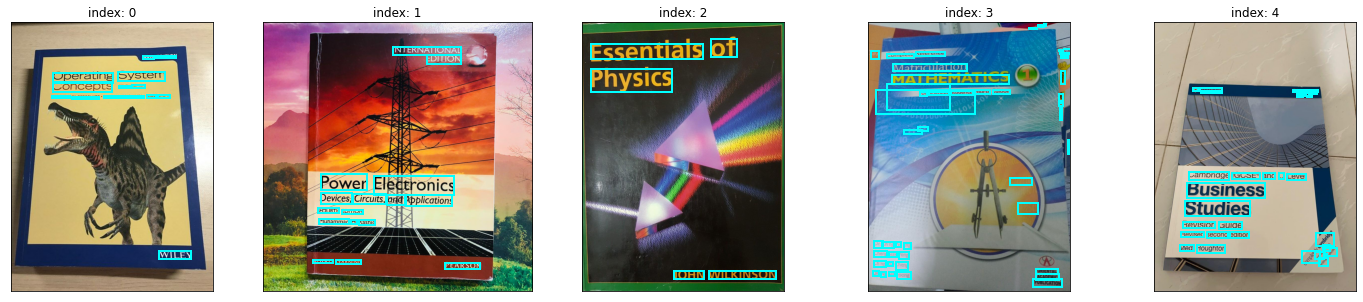

In [41]:
plt.figure(figsize=(20,20))

for i, img_path in enumerate(img_path_list):
    plt.subplot(5, 5, i+1)
    plt.title(f'index: {i}')
    
    text_pos_list = google_ocr_text_pos_list[i][1]
    text_list = google_ocr_text_list[i][1]
    text = ', '.join(text_list)

    for i, text_pos in enumerate(text_pos_list):
        if i == 0: continue
        w = text_pos[2][0]-text_pos[0][0]
        h = text_pos[2][1]-text_pos[0][1]
        rect = patches.Rectangle(
            (text_pos[0]),
            w, h,
            linewidth=2,
            edgecolor='cyan',
            fill=False
        )
        plt.gca().add_patch(rect)

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

#### keras_ocr

In [42]:
keras_ocr_text_pos_list

[[0, (array([[357.68805,  81.51301],
          [411.88562,  79.25477],
          [412.3518 ,  90.44367],
          [358.15424,  92.70191]], dtype=float32), array([[326.,  82.],
          [356.,  82.],
          [356.,  93.],
          [326.,  93.]], dtype=float32), array([[264.07812 , 120.816086],
          [383.19446 , 122.110825],
          [382.8913  , 149.99883 ],
          [263.77496 , 148.70409 ]], dtype=float32), array([[103.80293 , 124.06809 ],
          [256.88336 , 122.385895],
          [257.1844  , 149.7782  ],
          [104.10396 , 151.46039 ]], dtype=float32), array([[102., 149.],
          [254., 149.],
          [254., 176.],
          [102., 176.]], dtype=float32), array([[297., 155.],
          [333., 155.],
          [333., 164.],
          [297., 164.]], dtype=float32), array([[266., 156.],
          [296., 156.],
          [296., 164.],
          [266., 164.]], dtype=float32), array([[360.7041 , 179.01096],
          [394.95343, 177.74246],
          [395.29456, 1

In [43]:
keras_ocr_text_list

[[0,
  ('edition',
   'asia',
   'system',
   'operating',
   'concepts',
   'eomon',
   'tenta',
   'gagne',
   'greg',
   'galvin',
   'perer',
   'baer',
   'abratam',
   'silberschatz',
   'wiley')],
 [1,
  ('international',
   'edition',
   'power',
   'electronics',
   'devices',
   'circuits',
   'applications',
   'and',
   'fourth',
   'edition',
   'muhammad',
   'h',
   'rashid',
   'always',
   'learning',
   'pearson')],
 [2, ('of', 'essentials', 'physics', 'wilkinson', 'john')],
 [3,
  ('non',
   'lous',
   'ds',
   'd',
   'sas',
   'sinls',
   'fol',
   'sss',
   'con',
   'sasaen',
   'reference',
   'd',
   'complete',
   'cical',
   'matriculation',
   'mathematics',
   'l',
   's',
   'edition',
   'fourth',
   'students',
   'sciences',
   'for',
   's',
   'oototton',
   'polototton',
   'vtotoototo',
   '12',
   '11',
   '10',
   'wzin',
   'mntn',
   'ot',
   'h',
   'de',
   'ch',
   'pei',
   'eng',
   'ng',
   'cheng',
   'siak',
   'peng',
   'ching',
   'pe

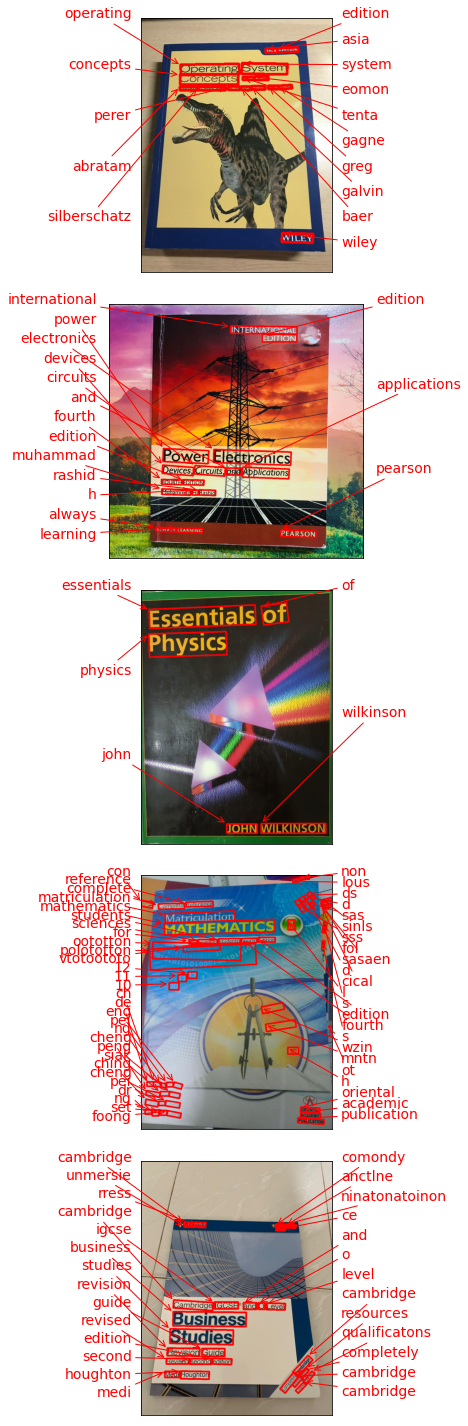

In [44]:
draw_keras_ocr(images, prediction_groups)

#### tesseract

In [45]:
tesseract_ocr_text_pos_list

[[0,
  [[(321, 70), (416, 70), (416, 99), (321, 99)],
   [(104, 123), (254, 123), (254, 149), (104, 149)],
   [(265, 123), (382, 123), (382, 147), (265, 147)],
   [(102, 150), (252, 150), (252, 174), (102, 174)],
   [(267, 156), (332, 156), (332, 164), (267, 164)],
   [(101, 184), (147, 184), (147, 190), (101, 190)],
   [(150, 183), (219, 183), (219, 191), (150, 191)],
   [(223, 185), (226, 185), (226, 188), (223, 188)],
   [(229, 183), (259, 183), (259, 189), (229, 189)],
   [(262, 182), (286, 182), (286, 189), (262, 189)],
   [(288, 177), (323, 177), (323, 188), (288, 188)],
   [(327, 183), (330, 183), (330, 186), (327, 186)],
   [(334, 181), (359, 181), (359, 187), (334, 187)],
   [(362, 180), (394, 180), (394, 187), (362, 187)],
   [(0, 0), (488, 0), (488, 666), (0, 666)]]],
 [1,
  [[(391, 679), (423, 679), (423, 693), (391, 693)],
   [(505, 692), (507, 692), (507, 694), (505, 694)],
   [(228, 691), (346, 691), (346, 736), (228, 736)],
   [(344, 692), (488, 692), (488, 731), (344, 

In [46]:
tesseract_ocr_text_list

[[0,
  ['ASIA EDITION\n\x0c',
   'Operating\n\x0c',
   'System\n\x0c',
   'Concepts\n\x0c',
   'TENTH EDITION\n\x0c',
   'ABRAM AM\n\x0c',
   'SILBERSCHAT2Z\n\x0c',
   '>\n\x0c',
   'PET ERM\n\x0c',
   'BAER\n\x0c',
   'GALVIN\n\x0c',
   'r\n\x0c',
   'Coby Cs\n\x0c',
   'GAGNE\n\x0c',
   '; |\n\x0c']],
 [1,
  ['wn\n\x0c',
   '~\n\x0c',
   'Devices\n\x0c',
   '; Circuits,\n\x0c',
   'UP\n\x0c',
   'FOURTH\n\x0c',
   'EDITION\n\x0c',
   '\x0c']],
 [2,
  ['—— eee\n\x0c',
   '10nd)\n\x0c',
   '\x0c',
   '.\n\x0c',
   '\x0c',
   '\x0c',
   '\x0c',
   'JOHN VWILKIN\n\x0c',
   '10)\n\x0c']],
 [3,
  ['..\n\x0c',
   'een\n\x0c',
   'li\n\x0c',
   'rceS ae\n\x0c',
   'Wn\n\x0c',
   'CS\n\x0c',
   '|\n\x0c']],
 [4,
  ['Es\n\x0c',
   'Cambridge\n\x0c',
   'I4C\n\x0c',
   'Business\n\x0c',
   'Studies\n\x0c',
   'ReVISION\n\x0c',
   '(j;ulde\n\x0c',
   'Revised\n\x0c',
   'SECOl}\n\x0c',
   'qd edition\n\x0c',
   'Medi\n\x0c',
   'mougnton\n\x0c',
   '=\n\x0c']]]

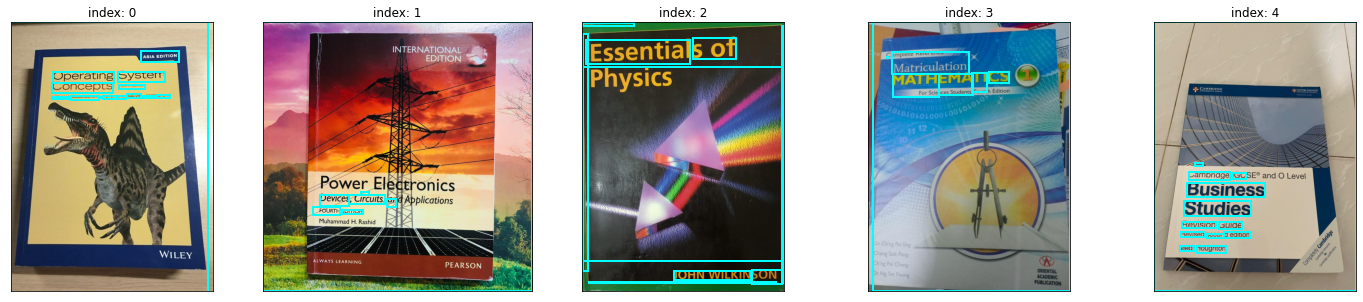

In [47]:
plt.figure(figsize=(20,20))

for i, img_path in enumerate(img_path_list):
    plt.subplot(5, 5, i+1)
    plt.title(f'index: {i}')
    
    text_pos_list = tesseract_ocr_text_pos_list[i][1]
    text_list = tesseract_ocr_text_list[i][1]
    text = ', '.join(text_list)

    for text_pos in text_pos_list:
        w = text_pos[2][0]-text_pos[0][0]
        h = text_pos[2][1]-text_pos[0][1]
        rect = patches.Rectangle(
            (text_pos[0]),
            w, h,
            linewidth=2,
            edgecolor='cyan',
            fill=False
        )
        plt.gca().add_patch(rect)

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

#### easyocr

In [48]:
easyocr_text_pos_list

[[0,
  [[325, 77], [415, 77], [415, 97], [325, 97]],
  [[100, 117], [389, 117], [389, 155], [100, 155]],
  [[98, 146], [256, 146], [256, 178], [98, 178]],
  [[266, 156], [296, 156], [296, 164], [266, 164]],
  [[296, 151], [335, 151], [335, 167], [296, 167]],
  [[102, 182], [220, 182], [220, 190], [102, 190]],
  [[228, 182], [258, 182], [258, 190], [228, 190]],
  [[261, 179], [327, 179], [327, 191], [261, 191]],
  [[333, 177], [397, 177], [397, 191], [333, 191]],
  [[362, 560], [452, 560], [452, 592], [362, 592]]],
 [1,
  [[510, 91], [799, 91], [799, 136], [510, 136]],
  [[645, 129], [799, 129], [799, 169], [645, 169]],
  [[220, 607], [780, 607], [780, 695], [220, 695]],
  [[218, 678], [770, 678], [770, 751], [218, 751]],
  [[219, 744], [404, 744], [404, 774], [219, 774]],
  [[220, 783], [457, 783], [457, 821], [220, 821]],
  [[196, 948], [398, 948], [398, 976], [196, 976]],
  [[722, 957], [881, 957], [881, 997], [722, 997]]],
 [2,
  [[18, 49], [633, 49], [633, 183], [18, 183]],
  [[19,

In [49]:
easyocr_text_list

[[0,
  'ASIA EDITION',
  'Operating System',
  'Concepts',
  'TENTH',
  'ECITION',
  'CRaHARSilaersChAtz',
  'PET CR',
  'BAER GALVIN',
  'GREG GAGNE',
  'WILEY'],
 [1,
  'INTERNATIONAL',
  'EDITION',
  'Power Eleetronics',
  'Devices, Circuits, and Applications',
  'FOURTH EDITION',
  'Muhammad H. Rashid',
  'ALWAYS LEARNING',
  'PEARSON'],
 [2, 'Essentials of', 'Physics', 'JOHN WILKINSON'],
 [3,
  'Complere Reference',
  'Matriculation',
  'MATHEMATICS',
  'For Sciences Students,Fourth Edition',
  'cOcooto',
  '[2050.05otozaoo,a8,ot070',
  'Ocoetetoteteotetetotota',
  '1112',
  'HO',
  'Dr',
  'Pej',
  'Siak',
  'Ch ng Pei',
  'Dr: Ng Set',
  'ORIENTAL',
  'AcAdEMIC',
  'PubLicATION',
  'ous',
  'Lent',
  'Con',
  '1',
  'Ching',
  'Eng',
  'Cheng',
  'Peng;',
  'Cheng',
  'Foong'],
 [4,
  'CAMKRIDGE',
  '[anaudat',
  'JTTeRn',
  'FRE',
  'Mtduemon',
  'Cambridge IGCSE" and 0 Level',
  'Business',
  'Studies',
  'Revision Guide',
  'Revised second edition',
  'Medi Houghton',
  '1',


### Step4. 결과 분석과 결론 제시

- 평가 기준: 외국 도서(전공 서적, 소설책 등) 표지에 있는 글자를 정확하게 추출했는가?

- OCR 모델 결과 분석

|OCR|book_1|book_2|book_3|book_4|book_5|Result Analysis|
|---|---|---|---|---|---|---|
|Google OCR API|'ASIA', 'EDITION', 'Operating', 'System', 'Concepts', 'TENTH', 'EDITION', 'ABRAHAM', 'SILBERSCHATZ', 'PETER', 'BAER', 'GALVIN.', 'GREG', 'GAGNE', 'WILEY'|'INTERNATIONAL',   'EDITION',   'Power',   'Electronics',   'Devices,',   'Circuits,',   'and',   'Applications',   'FOURTH',   'EDITION',   'Muhammad',   'H.',   'Rashid',   'ALWAYS',   'LEARNING',   'PEARSON'|'Essentials',   'of',   'Physics',   'JOHN',   'WILKINSON'|'n0101010101001010101010011A',   '0101001010110011e',   'A',   'Very',   'Short',   'For',   "Bank's",   'Con',   'Complete',   'Reference',   'SA/SA-IN',   'CA/CA',   'Matriculation',   'MATHEMATICS',   'For',   'Sciences',   'Students,',   'Fourth',   'Edition',   '77',   '12',   '002110',   '12547',   'Dr.',   "Ch'ng",   'Pei',   'Eng',   'Cheng',   'Siak',   'Peng',   "Ch'ng",   'Pei',   'Cheng',   'ORIENTAL',   'ACADEMIC',   'PUBLICATION',   'Dr.',   'Ng',   'Set',   'Foong',   'FURM',   'Cepa',   'vat',   '&',   'Der'|'.',   'CAMBRIDGE',   'UNIVERSITY',   'PRESS',   'BCambridge',   'Assessment',   'International',   'Education',   'tedersed',   'or',   'even',   'Cambridge',   'IGCSE®',   'and',   'O',   'Level',   'Business',   'Studies',   'Revision',   'Guide',   'Revised',   'second',   'edition',   'Medi',   'Houghton',   'Completely',   'Cambridge',   'Cambridge',   'resources',   'Jog',   'Cambridge',   'qualifications'|검출 정확도 1등|
|keras_ocr|'abratam',   'asia',   'baer',   'concepts',   'edition',   'eomon',   'gagne',   'galvin',   'greg',   'operating',   'perer',   'silberschatz',   'system',   'tenta',   'wiley'|'always',   'and',   'applications',   'circuits',   'devices',   'edition',   'edition',   'electronics',   'fourth',   'h',   'international',   'learning',   'muhammad',   'pearson',   'power',   'rashid'|'essentials', 'john', 'of', 'physics', 'wilkinson'|'10',   '11',   '12',   'academic',   'ch',   'cheng',   'cheng',   'ching',   'cical',   'complete',   'con',   'd',   'd',   'de',   'dr',   'ds',   'edition',   'eng',   'fol',   'foong',   'for',   'fourth',   'h',   'l',   'lous',   'mathematics',   'matriculation',   'mntn',   'ng',   'ng',   'non',   'oototton',   'oriental',   'ot',   'pei',   'pei',   'peng',   'polototton',   'publication',   'reference',   's',   's',   'sas',   'sasaen',   'sciences',   'set',   'siak',   'sinls',   'sss',   'students',   'vtotoototo',   'wzin'|'anctlne',   'and',   'business',   'cambridge',   'cambridge',   'cambridge',   'cambridge',   'cambridge',   'ce',   'comondy',   'completely',   'edition',   'guide',   'houghton',   'igcse',   'level',   'medi',   'ninatonatoinon',   'o',   'qualificatons',   'resources',   'revised',   'revision',   'rress',   'second',   'studies',   'unmersie'|검출 정확도 2등|
|tesseract|'ASIA EDITION\n\x0c',   'Operating\n\x0c',   'System\n\x0c',   'Concepts\n\x0c',   'TENTH EDITION\n\x0c',   'ABRAM AM\n\x0c',   'SILBERSCHAT2Z\n\x0c',   '>\n\x0c',   'PET ERM\n\x0c',   'BAER\n\x0c',   'GALVIN\n\x0c',   'r\n\x0c',   'Coby Cs\n\x0c',   'GAGNE\n\x0c',   ';|'wn\n\x0c',   '~\n\x0c',   'Devices\n\x0c',   '; Circuits,\n\x0c',   'UP\n\x0c',   'FOURTH\n\x0c',   'EDITION\n\x0c',   '\x0c'|'—— eee\n\x0c',   '10nd)\n\x0c',   '\x0c',   '.\n\x0c',   '\x0c',   '\x0c',   '\x0c',   'JOHN VWILKIN\n\x0c',   '10)\n\x0c'|'..\n\x0c',   'een\n\x0c',   'li\n\x0c',   'rceS ae\n\x0c',   'Wn\n\x0c',   'CS\n\x0c',   '|'Es\n\x0c',   'Cambridge\n\x0c',   'I4C\n\x0c',   'Business\n\x0c',   'Studies\n\x0c',   'ReVISION\n\x0c',   '(j;ulde\n\x0c',   'Revised\n\x0c',   'SECOl}\n\x0c',   'qd edition\n\x0c',   'Medi\n\x0c',   'mougnton\n\x0c',   '=\n\x0c'|검출 정확도 3등|
|easyocr|'ASIA EDITION',  'Operating System',  'Concepts',  'TENTH',  'ECITION',  'CRaHARSilaersChAtz',  'PET CR',  'BAER GALVIN',  'GREG GAGNE',  'WILEY'|'INTERNATIONAL',  'EDITION',  'Power Eleetronics',  'Devices, Circuits, and Applications',  'FOURTH EDITION',  'Muhammad H. Rashid',  'ALWAYS LEARNING',  'PEARSON'|'Essentials of', 'Physics', 'JOHN WILKINSON'|'Complere Reference',  'Matriculation',  'MATHEMATICS',  'For Sciences Students,Fourth Edition',  'cOcooto',  '[2050.05otozaoo,a8,ot070',  'Ocoetetoteteotetetotota',  '1112',  'HO',  'Dr',  'Pej',  'Siak',  'Ch ng Pei',  'Dr: Ng Set',  'ORIENTAL',  'AcAdEMIC',  'PubLicATION',  'ous',  'Lent',  'Con',  '1',  'Ching',  'Eng',  'Cheng',  'Peng;',  'Cheng',  'Foong'|'CAMKRIDGE',  '[anaudat',  'JTTeRn',  'FRE',  'Mtduemon',  'Cambridge IGCSE" and 0 Level',  'Business',  'Studies',  'Revision Guide',  'Revised second edition',  'Medi Houghton',  '1',  '1',  '1',  '[',  '1',  'nbrdye €']|검출 정확도 4등|

- 결론
  - 1순위 선택: Google OCR API
    - 이유
      - 가장 정확했다.
      - 영어와 한글을 동시에 추출할 수 있다. 다른 OCR 모델은 언어를 시작 전에 지정해줘야만 했기 때문에 동시에 다른 언어의 글자를 얻기 힘들었다.
  - 2순위 선택: keras_ocr
    - 이유
      - Google OCR API 다음으로 가장 정확했다.
      - 영어와 한글을 동시에 추출하진 못하지만 영어만 추출해봤을 때 성능이 준수했음을 볼 수 있었다.
  - 나머지 OCR 모델
    - 추출해야 할 글자가 더 있음에도 불구하고 찾아내지 못했다.
    - 완전한 한 단어가 아니라 한 단어를 끊어서 추출하는 모습을 보였다.

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
라이브러리가 또, 또, 또!!!! 말썽부려서 성격이 점점 더 나빠지고 있다. OCR 결과를 시각화하려고 완전 고생했다. 마음처럼 잘 안 되니까 많이 힘들었다...

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 파이썬 OCR 라이브러리로 google-cloud-vision, keras_ocr, pytesseract 말고도 easyocr 을 사용해봤다. [[참고]](https://medium.com/mlearning-ai/tesseract-vs-keras-ocr-vs-easyocr-ec8500b9455b)
  - [google-cloud-vision](https://cloud.google.com/vision) [[docs]](https://cloud.google.com/vision/docs): 구글 클라우드 기반 OCR API 사용
  - [keras_ocr](https://github.com/faustomorales/keras-ocr) [[document]](https://keras-ocr.readthedocs.io/en/latest/): CRNN 사용, 검출 모델 CRAFT(Character Region Awareness for Text Detection) 사용
  - [pytesseract](https://github.com/madmaze/pytesseract): a wrapper for [Google's Tesseract-OCR Engine](https://github.com/tesseract-ocr/tesseract)
  - [easyocr](https://github.com/JaidedAI/EasyOCR)
    - ![](https://github.com/JaidedAI/EasyOCR/blob/master/examples/easyocr_framework.jpeg?raw=true)
2. OCR(Optical Character Recognition, 광학 문자 인식)
  - 사용 용도: 종이 서류(영수증, 계약서, 책 표지 등 인쇄된 문서/이미지) -> 전자화
  - 인식(Detection) -> 해독(Recognition)
  - 딥러닝 기반 Object Detection: Regression(회귀), Segmentation(세그멘테이션)
  - 딥러닝 기반 Recognition: CRNN (=CNN + RNN)
    - CNN: 이미지 내 텍스트와 연관된 특징 추출
    - RNN: 스텝 단위 문자 정보 인식


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
>|2|모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
>|3|평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

외국 도서(전공 서적, 소설책 등) 표지에 있는 글자를 추출해서 도서의 정보(원가격, 출판사 등)를 검색하는 서비스를 만들기 위해서 OCR을 적용한다는 컨셉으로 진행했다. 도서명과 해당 도서 표지에 있는 텍스트 데이터를 잘 검출해냈다.

평가 기준은 텍스트 데이터(도서 제목, 부제목, 출판사, 작가)를 정확하게 검출했는가로 잡았다.

테스트 이미지로 외국 도서 표지 20장을 구했다. 각 ocr 라이브러리마다 결과를 확인했고 마지막에 결론까지 정리했다. Google OCR API 가 가장 정확히 검출했다. tesseract 과 easyocr 은 검출을 제대로 하지 못했고 그나마 검출한 것조차 정확하지 않아서 서비스 개발로 적합하지 않았다. keras-ocr 은 무난한 정확도를 보였다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
라이브러리 때문에 오류가 터지는 상황은 나 혼자 다짐한다고 해결되지 않는다. 

---
- 대나무숲
라이브러리 오류 때문에 열받아서 미쳐버리겠다! 이미 미치긴 했지만 더 미쳐가고 있다. LMS 클라우드에서 패키지 설치가 안 되길래 어쩔 수 없이 Colab 으로 꾸역꾸역 했다. Colab 결제 덕분에 빠른 건 만족스럽지만 가독성이 안 좋고 매우 불편하다!